# Projet Vélib' - MDI230

#### 21/06/2022

Rémy TANG, Liwei YAO, Darius MUNGUR

## Introduction

Dans le cadre du cours de file d’attente, on se propose de modéliser puis simuler l’évolution d’un système de vélos partagés par un modèle des colonies à migration fermée. Les données utilisées proviennent des stations 3 à 7 du réseau de Vélib' de Rouen, qui compte au total 91 vélos.

## Hypothèses

On suppose que le nombre de stations et de vélos sont fixes, et que tous les trajets sont possibles tant que le vélo change de station.

Les trois paramètres du modèle (obtenus par la partie modélisation et dont les valeurs proviennent des données fournies) sont : 

- la matrice de routage $P_{i,j}$
- le taux de départ $\lambda_i$ 
- le temps de trajet moyen $\tau_{ij}$. 

## Simulation

### Q3 - Simulez les trajectoires du processus de Markov

La fonction `simulation_processus_markov` prend à l’entrée la configuration initiale et le nombre d'heures à simuler, en plus des 3 paramètres du modèle. Pour une certaine durée totale de simulation, on calcule à chaque état le taux de transition des départs et des arrivées dans les stations, avant de faire des tirages suivant la loi exponentielle correspondante. Ainsi, chaque taux de transition est le paramètre de la loi exponentielle régissant la durée avant la prochaine transition.

Enfin, l'intervalle de temps entre l’état présent et le prochain état est régit par le minimum des lois exponentielles tirées à chaque fois. En effet, comme la loi exponentielle est sans mémoire, l'intervalle de temps avant la transition suivante est obtenu en faisant de nouveaux tirages et en oubliant ceux précédemment obtenus.

In [1]:
# Libraries utiles
import numpy as np
from numpy import unravel_index
import numpy.ma as ma

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
sns.set_style(style='whitegrid')
sns.set_context(context='paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

from numba import jit

In [2]:
# Initialisation des données

# Temps de trajet en minutes de la station i vers la station j tau(i,j)
temps_trajet = np.array([[0, 3, 5, 7, 7],
                         [2, 0, 2, 5, 5],
                         [4, 2, 0, 3, 3],
                         [8, 6, 4, 0, 2],
                         [7, 7, 5, 2, 0]])
# Convertion des temps de trajet en secondes
temps_trajet = temps_trajet * 60

# Taux de départ par heure pour la station i : lambda(i)
taux_depart = np.array([2.8, 3.7, 5.5, 3.5, 4.6])
# Convertion en taux de départ par seconde
taux_depart = taux_depart/(60*60)

# Matrice de routage p(i,j)
routage = np.array([[0, 0.22, 0.32, 0.2, 0.26],
                    [0.17, 0, 0.34, 0.21, 0.28],
                    [0.19, 0.26, 0, 0.24, 0.31],
                    [0.17, 0.22, 0.33, 0, 0.28],
                    [0.18, 0.24, 0.35, 0.23, 0]])

# État initial
# Nombre de vélos par station sur la diagonale
# Nombre de vélos en trajet t[i,j] ailleurs
etat_init = np.array([[20, 1, 0, 0, 0],
                       [1, 15, 1, 0, 0],
                       [0, 1, 17, 1, 0],
                       [0, 0, 1, 13, 1],
                       [0, 0, 0, 1, 18]])

print("Nombre de vélos :", np.sum(etat_init))

Nombre de vélos : 91


In [12]:
@jit
def simulation_processus_markov(temps_trajet, taux_depart, routage, etat_init, n_heures):
    """
    Simulation des trajectoires du processus de Markov,
    avec des intervalles entre les départs suivant une loi exponentielle.

    :param temps_trajet: matrice des temps de trajet entre stations
    :param taux_depart: taux de départ par seconde pour chaque station
    :param routage: matrice de routage
    :param etat_init: état initial
    """
    # Initialisation
    t = [0]                     # Axe du temps en secondes, à chaque valeur correspond à un changement d'état
    traj_last = 0               # Dernier trajet
    trajectoire = [etat_init]   # Liste des états
    
    while (t[traj_last] < n_heures*60*60):
        # Taux de transition des départs depuis chaque station vers les trajets à l'instant t
        taux_transition_departs = np.zeros((len(temps_trajet), len(temps_trajet[0])))
        for i in range(len(etat_init)):
            for j in range(len(etat_init[0])):
                if (i!=j):
                    # Le min correspond à l'indicatrice qui indique s'il y a au moins un vélo dans la station i
                    taux_transition_departs[i, j] = routage[i, j] * taux_depart[i] * min(trajectoire[traj_last][i,i], 1)

        # Taux de transition des arrivées depuis les trajets vers chaque station l'instant t
        taux_transition_arrivees = np.zeros((len(temps_trajet), len(temps_trajet[0])))
        for i in range(len(etat_init)):
            for j in range(len(etat_init[0])):
                if (i!=j):
                    # On multiplie par le minimum de n=trajectoire[t][i,j] lois exponentielles
                    taux_transition_arrivees[i, j] = 1/temps_trajet[i, j] * trajectoire[traj_last][i,j]
        
        # Calcul de la prochaine transition
        nouvel_etat = trajectoire[traj_last].copy()
        choix_transition_depart_unmask = np.zeros((len(etat_init), len(etat_init[0])))
        choix_transition_arrivee_unmask = np.zeros((len(etat_init), len(etat_init[0])))

        for i in range(len(etat_init)):
            for j in range(len(etat_init[0])):
                if (i!=j):
                    # On fait des tirages pour chaque transition non nulle à partir des lois exponentiellles
                    if (taux_transition_departs[i, j]!=0):
                        choix_transition_depart_unmask[i, j] = np.random.exponential(1/taux_transition_departs[i, j])
                    else:
                        choix_transition_depart_unmask[i, j] = np.Inf
                    if (taux_transition_arrivees[i, j]!=0):
                        choix_transition_arrivee_unmask[i, j] = np.random.exponential(1/taux_transition_arrivees[i, j])
                    else:
                        choix_transition_arrivee_unmask[i, j] = np.Inf


        # # On applique un masque sur les matrices pour ne pas prendre en compte les valeurs diagonales qui valent 0 -> désactivé car incompatible avec jit
        # choix_transition_depart = ma.masked_array(choix_transition_depart_unmask, mask=choix_transition_depart_unmask==0)
        # choix_transition_arrivee = ma.masked_array(choix_transition_arrivee_unmask, mask=choix_transition_arrivee_unmask==0)
        choix_transition_depart = choix_transition_depart_unmask + np.diag(np.Inf * np.ones(len(etat_init)))
        choix_transition_arrivee = choix_transition_arrivee_unmask + np.diag(np.Inf * np.ones(len(etat_init)))
        
        # On garde le temps minimum à partir des tirages pour obtenir la prochaine transition
        # Comme le processus est sans mémoire, on refait un tirage sur toutes les variables aléatoires après cette transition
        dep_min = np.min(choix_transition_depart)
        arr_min = np.min(choix_transition_arrivee)
        # Indice de l'élément le plus petit parmi les deux matrices
        if dep_min < arr_min:
            # idx = unravel_index(choix_transition_depart.argmin(), choix_transition_depart.shape) -> désactivé car incompatible avec jit
            idx = (choix_transition_depart.argmin()//len(choix_transition_depart[0]), choix_transition_depart.argmin()%len(choix_transition_depart[0]))
            nouvel_etat[idx[0], idx[0]] -= 1 # On enlève un vélo de la station
            nouvel_etat[idx[0], idx[1]] += 1 # On ajoute un vélo sur le trajet
            tps = dep_min
        else:
            # idx = unravel_index(choix_transition_arrivee.argmin(), choix_transition_arrivee.shape) -> désactivé car incompatible avec jit
            idx = (choix_transition_arrivee.argmin()//len(choix_transition_arrivee[0]), choix_transition_arrivee.argmin()%len(choix_transition_arrivee[0]))
            nouvel_etat[idx[0], idx[1]] -= 1 # On enlève un vélo sur le trajet
            nouvel_etat[idx[1], idx[1]] += 1 # On ajoute un vélo sur la station
            tps = arr_min
        
        # On ajoute la date de la transition à t
        t.append(tps+t[traj_last])

        traj_last += 1
        trajectoire.append(nouvel_etat)

    return trajectoire, t

Simulons les trajectoires des stations sur 24 heures en guise d'aperçu du système.

In [19]:
# Simulation sur n_heures
n_heures = 24
trajectoire, temps = simulation_processus_markov(temps_trajet, taux_depart, routage, etat_init, n_heures)

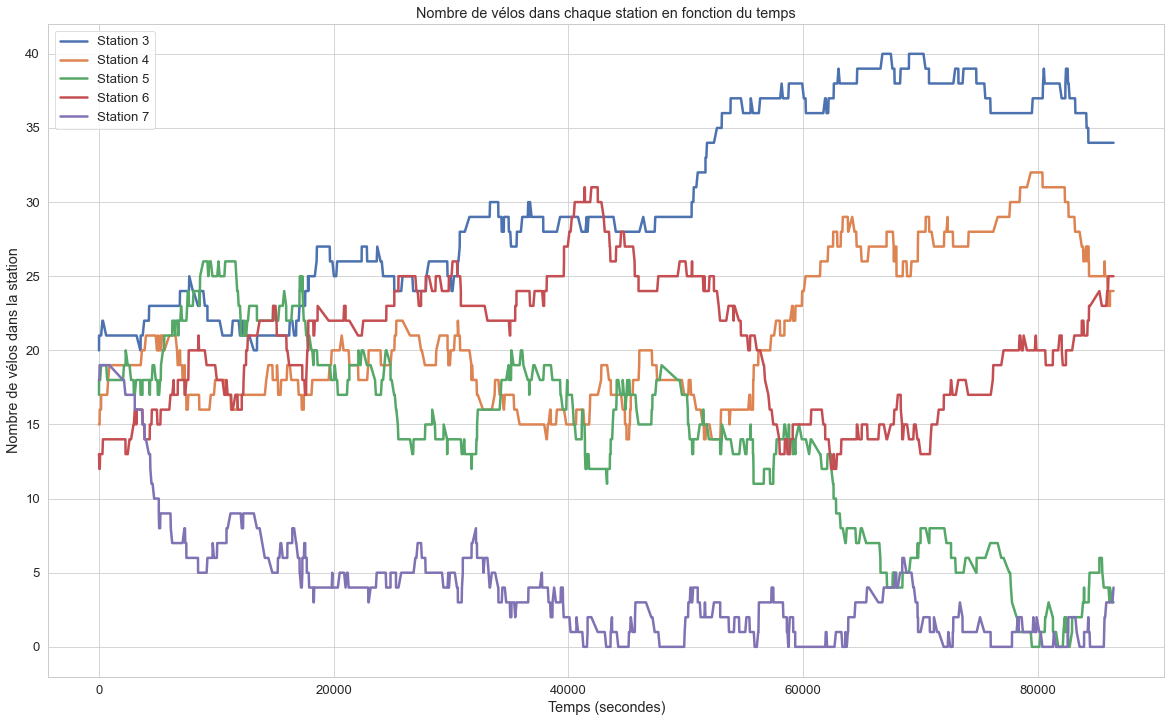

In [20]:
# Affichage du nombre de vélos pour chaque station
traj = np.array(trajectoire)

traj3 = traj[:,0,0]
traj4 = traj[:,1,1]
traj5 = traj[:,2,2]
traj6 = traj[:,3,3]
traj7 = traj[:,4,4]

plt.figure(figsize=(20,12))
sns.lineplot(x=temps, y=traj3, label="Station 3")
sns.lineplot(x=temps, y=traj4, label="Station 4")
sns.lineplot(x=temps, y=traj5, label="Station 5")
sns.lineplot(x=temps, y=traj6, label="Station 6")
sns.lineplot(x=temps, y=traj7, label="Station 7")
plt.xlabel("Temps (secondes)")
plt.ylabel("Nombre de vélos dans la station")
plt.title("Nombre de vélos dans chaque station en fonction du temps")
plt.legend()
plt.show()

In [6]:
# Affichage des deux premiers intervalles de temps pour les premières transition
print(temps[1]-temps[0], temps[2]-temps[1])

2.1623525622864537 12.285478794741627


On observe d'une part que l'intervalle de temps entre les transitions varie bien, conformément à nos tirages. 

D'autre part, en relançant la simulation plusieurs fois, on obtient des résultats différents (la ou les station(s) qui n'ont plus aucun vélo à la fin change(nt)), ce qui montre que l'on a bien traduit l'aspect probabiliste du phénomène modélisé.

### Q4 - En déduire la probabilité que chaque station soit vide après 150 heures

Par ergodicité, la probabilité que chaque station soit vide au bout de 150 heures peut être approchée en réitérant la simulation un grand nombre de fois. 

Approchons donc les probabilités demandées de cette manière pour 1000 itérations (temps de calcul ~20 secondes).  

In [7]:
def calcul_proba_station_vide(n_iterations, n_heures, etat_init):
    """
    Fonction qui calcule les probabilités d'avoir une station vide au bout d'un temps n_heures donné,
    à partir de n_iterations simulations

    :param n_iterations: nombre de simulations
    :param n_heures: nombre d'heures à simuler
    :return: probabilité de station vide
    """
    nb_station_vide = np.zeros(len(etat_init))
    for i in range(n_iterations):
        trajectoire, _ = simulation_processus_markov(temps_trajet, taux_depart, routage, etat_init, n_heures)
        traj = np.array(trajectoire)
        for j in range(len(etat_init)):
            if (traj[-1,j,j] == 0):
                nb_station_vide[j] +=1

    return nb_station_vide/n_iterations

In [8]:
# Simulation sur n_iterations
n_iterations = 1000
n_heures = 150

probas_station_vide = np.array(calcul_proba_station_vide(n_iterations, n_heures, etat_init))

In [9]:
for i in range(len(probas_station_vide)):
    print("La probabilité que la station", i+3, "soit vide au bout de", n_heures, "heures est", probas_station_vide[i])

La probabilité que la station 3 soit vide au bout de 150 heures est 0.019
La probabilité que la station 4 soit vide au bout de 150 heures est 0.045
La probabilité que la station 5 soit vide au bout de 150 heures est 0.149
La probabilité que la station 6 soit vide au bout de 150 heures est 0.051
La probabilité que la station 7 soit vide au bout de 150 heures est 0.103


### Q5 - Calculer l’intervalle de confiance de ce résultat

Les résultats précédents n'ont que peu d'intérêts sans les intervalles de confiance. Il s'agit maintenant de les calculer, ici avec un taux de confiance de 95%.

In [10]:
import re

def calcul_ecarts(n_iterations, probas):
    """
    Calcule les intervalles de confiance d'un vecteur de valeurs à partir du nombre d'itérations.

    :param n_iterations: nombre de simulations
    :param probas: probabilités attendues
    """
    sigma = [0, 0, 0, 0, 0]
    ecart = [0, 0, 0, 0, 0]
    nb_chiffres_significatifs = [len(str(probas_station_vide[i])) - 2 for i in range(len(probas_station_vide))]

    for i in range(len(probas)):
        sigma[i] = np.sqrt(n_iterations/(n_iterations-1) * (probas[i] - probas[i]**2))
        ecart[i] = 1.96 * sigma[i]/np.sqrt(n_iterations)

        ec = round(ecart[i], nb_chiffres_significatifs[i])
        print("La probabilité que la station", i+3, "soit vide au bout de", n_heures, "heures est", probas[i], "+/-", ec)

In [11]:
# Intervalles de confiance pour la simulation avec 100 itérations
calcul_ecarts(n_iterations, probas_station_vide)

La probabilité que la station 3 soit vide au bout de 150 heures est 0.019 +/- 0.008
La probabilité que la station 4 soit vide au bout de 150 heures est 0.045 +/- 0.013
La probabilité que la station 5 soit vide au bout de 150 heures est 0.149 +/- 0.022
La probabilité que la station 6 soit vide au bout de 150 heures est 0.051 +/- 0.014
La probabilité que la station 7 soit vide au bout de 150 heures est 0.103 +/- 0.019


## Calculs théoriques

### Q6 - Utilisez les équations de trafic pour obtenir les relations entre les $\alpha_i$

Posons :
- $E = \{1,2,3,4,5, t_{1,2}, t_{1,3}, ..., t_{5,3}, t_{5,4}\}$,
- $S = \{1,2,3,4,5\}$,
- $T = \{t_{1,2}, t_{1,3}, ..., t_{5,3}, t_{5,4}\}$

D'après le cours sur les colonies (et en utilisant les mêmes notations pour les variables), les équations de trafic lorsqu'un seul vélo évolue dans le système sont :

$$
\begin{equation*}
\alpha_j >0, \forall j \in E
\end{equation*}
$$

$$
\begin{equation*}
\sum_j \alpha_j = 1
\end{equation*}
$$

$$
\begin{equation*}
\alpha_j \sum_k \lambda_{jk} = \sum_k \alpha_k \lambda_{kj}, \forall j \in E
\end{equation*}
$$

Comme les seules transitions possibles sont entre une station et un trajet, on peut remplacer les $\lambda_{ij}$ par leur valeur.

Rappelons, avec les notations de l'énoncé :
- en partant d'une station $j$ vers le trajet $t_{j,k}$, 
$\lambda_{jk} = \lambda_j \times p_{jk} $
- en partant d'un trajet $t_{k,j}$ vers la station $j$,
$\lambda_{kj} = \frac{1}{\tau_{kj}} $

Donc le système devient :

$$
\begin{equation*}
\alpha_j >0, \forall j \in E
\end{equation*}
$$

$$
\begin{equation*}
\sum_{j \in E} \alpha_j = 1
\end{equation*}
$$

$$
\begin{equation*}
\alpha_j \lambda_j \sum_{k \in S, \, k\ne j} p_{jk} = \sum_{k \in S, \, k\ne j} \frac{\alpha_{t_{k,j}}}{\tau_{kj}} 
\end{equation*}
$$


Comme :
- $\sum_{k \in S, \, k\ne j} p_{jk} = 1$ par définition
- $\forall (j,k) \in S^2, j\ne k, \frac{\alpha_{t_{k,j}}}{\tau_{kj}} = \alpha_k \lambda_k p_{kj}  \, (1)$

Alors :

$$
\begin{equation*}
\alpha_j >0, \forall j \in E
\end{equation*}
$$

$$
\begin{equation*}
\sum_{j \in E} \alpha_j = 1
\end{equation*}
$$

$$
\begin{equation*}
\sum_{k \in S, \, k\ne j} (\alpha_k \lambda_k p_{kj}) - \alpha_j \lambda_j = 0
\end{equation*}
$$

Ce qui revient à résoudre $M\alpha=0$, avec :

- $\forall i \in S, \, \, M_{i-1 \, i-1} = -\lambda_i$
- $\forall (i,j) \in S^2, i\ne j, M_{i-1 \, j-1} = \lambda_j \times p_{ji}$
- $\alpha = (\alpha_1 \, \alpha_2 \, \alpha_3 \, \alpha_4 \, \alpha_5)^T$

En suivant l'indice donné dans l'énoncé, on remplace alors la première ligne par des 1 pour ne pas avoir une solution nulle en utilisant l'équation de normalisation.

Cela revient à résoudre $M\alpha=X$, avec :

- $\forall j \in S, \,M_{0 \, j-1} = 1$ 
- $\forall i \in S \setminus \{1\}, \, \, M_{i-1 \, i-1} = -\lambda_i$
- $\forall (i,j) \in (S\setminus \{1\}) \times S, i\ne j, M_{i-1 \, j-1} = \lambda_j \times p_{ji}$
- $X = (1 \; 0 \; 0 \; 0\; 0)^T$

D'où :

$$\alpha=M^{-1}X$$

Et on peut déduire les autres coefficients $\alpha_{t_{k,j}}$ en utilisant $(1)$.

### Q7 - On considère qu’il n’y a qu’un seul vélo, quelle est alors la taille de l’espace d’état ?

Nous avons toujours 5 stations de Vélib' et donc 25 colonies au total dans notre modèle (une pour chaque station, plus $5 \times 4 = 20$ pour les trajets).

Comme chacune des colonies est accessible depuis n'importe quelle autre, et que le vélo ne peut se trouver qu'à une colonie à la fois, chaque état est décrit par un vecteur de taille 25  de la forme $(0, ..., 0, 1, 0, ..., 0)$, avec que des zéros sauf pour une des 25 composantes qui vaut 1.

L'espace d'état est donc de taille 25.

### Q8 - Dans ces conditions (un seul vélo), calculer la probabilité que chaque station soit vide 

On commence par utiliser les résultats de la question 6 pour faire calculer numériquement les $\alpha_i$.

In [12]:
X = np.array([1, 0, 0, 0, 0])
M = np.zeros(shape=(5,5))

# La première ligne ne contient que des 1
for i in range(len(M)):
    M[0,i] = 1

# Les autres lignes contiennent les lambdas (cf Q6)
for i in range(1, len(M)):
    for j in range(len(M)):
        if i == j:
            M[i,j] = -taux_depart[i]
        else:
            M[i,j] = taux_depart[j] * routage[j,i]

alpha = np.linalg.inv(M) @ X
print("alpha =", alpha)

alpha = [0.21452558 0.20598155 0.18149152 0.20641427 0.19158707]


On calcule également les $\alpha_{t_{k,j}}$ en utilisant $(1)$, et on définit une matrice pour regrouper toutes les valeurs des $\alpha_i$ comme suit :

In [13]:
alphas = np.zeros(shape=(5,5))
# La diagonale est le vecteur alpha
alphas = alphas + np.diag(alpha)
# Les éléments [i,j] sont les alpha_t[i+1,j+1]
for i in range(len(alphas)):
    for j in range(len(alphas)):
        if i != j:
            alphas[i,j] = alpha[i] * taux_depart[i] * routage[i,j] * temps_trajet[i,j]

print(alphas)

[[0.21452558 0.00660739 0.01601791 0.01401567 0.01822037]
 [0.00431875 0.20598155 0.00863749 0.01333731 0.01778307]
 [0.01264391 0.0086511  0.18149152 0.01197844 0.01547215]
 [0.01637553 0.0158939  0.0158939  0.20641427 0.00674287]
 [0.01850731 0.02467642 0.0257046  0.00675664 0.19158707]]


D'après le théorème 2.4, la distribution à l'équilibre pour le processus de migration fermé est :

$$
\pi(n) = G_N^{-1} \prod_{j \in E} \frac{\alpha_j^{n_j}}{\prod_{r=1}^{n_j} \phi_j(r)}
$$

Comme on n'a qu'un seul vélo, pour un $k$ donné, les $\alpha_j$ valent tous $1$ sauf un seul (en $k$). On peut donc simplifier et donner directement la probabilité de trouver le vélo en k-ème position du vecteur d'état :

$$
\pi(n_k) = G_N^{-1} \frac{\alpha_k}{\phi_j(1)} = G_N^{-1} \alpha_k, \, k \in E
$$

Ainsi, la probabilité que la station $k$ soit vide est obtenue en calculant simplement $1 - \pi(n_k) = 1 - \mathbb{P}(n_k = 1) = \mathbb{1} - \alpha \times G_N^{-1}$, en choisissant $G_N$ de manière à satisfaire la condition de normalisation sur la distribution :

$$
\begin{align*}
\sum_{k \in E} \pi(n_k) &= \sum_{k \in E} G_N^{-1} \alpha_k
\\
                        &= G_N^{-1} \sum_{k \in E} \alpha_k = 1
\end{align*}
$$

D'où :

$$
G_N = \sum_{k \in E} \alpha_k
$$

On peut finalement calculer la distribution à l'équilibre pour l'ensemble des stations.

In [14]:
G_N = alphas.sum()
probas_station_vide_theorique = np.ones(len(alpha)) - alpha / G_N
print("Distribution à l'équilibre avec un seul vélo :", probas_station_vide_theorique)

Distribution à l'équilibre avec un seul vélo : [0.83217043 0.83885467 0.85801393 0.83851615 0.85011589]


### Q9 - Comparez aux résultats obtenus par simulation

Avec cette fois un seul vélo, on simule sur 1000 heures pour obtenir les probabilités empiriques que chaque station soit vide. De plus, on initialise la position du vélo de manière aléatoire dans le système à chaque itération.

In [15]:
n_iteration = 1000
n_heures = 1000

# La position initial du vélo est initialisée aléatoirement
pos_init_velo = np.random.randint(len(routage), size=n_iteration)

station_vide = np.zeros(5)
for pos in pos_init_velo:
    etat_init_velo = np.zeros((len(routage), len(routage)))
    idx = unravel_index(pos, etat_init_velo.shape)
    etat_init_velo[idx] = 1
    # On fait une seule itération à chaque fois pour avoir directement la position de la station vide (s'il y en a une)
    station_vide += np.array(calcul_proba_station_vide(1, n_heures, etat_init_velo))

probas_station_vide_2 = station_vide/n_iteration

calcul_ecarts(n_iterations, probas_station_vide_2)

La probabilité que la station 3 soit vide au bout de 1000 heures est 0.952 +/- 0.013
La probabilité que la station 4 soit vide au bout de 1000 heures est 0.953 +/- 0.013
La probabilité que la station 5 soit vide au bout de 1000 heures est 0.952 +/- 0.013
La probabilité que la station 6 soit vide au bout de 1000 heures est 0.961 +/- 0.012
La probabilité que la station 7 soit vide au bout de 1000 heures est 0.954 +/- 0.013


Les probabilités empiriques obtenues, même en prenant en compte les intervalles de confiance, restent éloignées des résultats théoriques obtenus.

## Simulation pour 100 vélos

### Q10 - Simuler le même réseau avec 100 vélos, initialement répartis de façon uniforme entre les stations et les routes

On initialise l'état initial en répartissant les 100 vélos de manière uniforme dans les 25 colonies, ce qui nous donne 4 vélos par colonie.

In [16]:
# Initialisation avec 100 vélos uniformement répartis
etat_init_3 = np.ones((5,5)) * 4
print(etat_init_3)

[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]


In [17]:
# Simulation sur n_heures
n_heures = 150
trajectoire, temps = simulation_processus_markov(temps_trajet, taux_depart, routage, etat_init_3, n_heures)

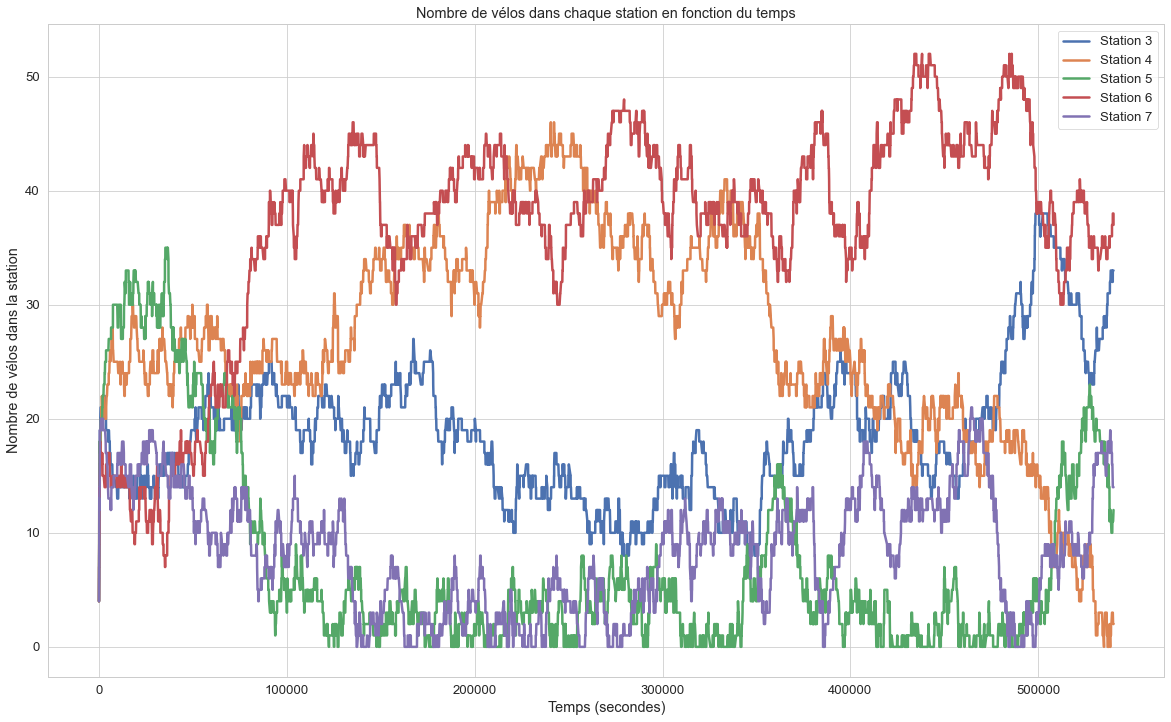

In [18]:
# Affichage du nombre de vélos pour chaque station
traj = np.array(trajectoire)

traj3 = traj[:,0,0]
traj4 = traj[:,1,1]
traj5 = traj[:,2,2]
traj6 = traj[:,3,3]
traj7 = traj[:,4,4]

plt.figure(figsize=(20,12))
sns.lineplot(x=temps, y=traj3, label="Station 3")
sns.lineplot(x=temps, y=traj4, label="Station 4")
sns.lineplot(x=temps, y=traj5, label="Station 5")
sns.lineplot(x=temps, y=traj6, label="Station 6")
sns.lineplot(x=temps, y=traj7, label="Station 7")
plt.xlabel("Temps (secondes)")
plt.ylabel("Nombre de vélos dans la station")
plt.title("Nombre de vélos dans chaque station en fonction du temps")
plt.legend()
plt.show()

Puis on peut recalculer les probabilités d'avoir une station vide au bout de 150 heures.

In [19]:
n_iteration = 1000
n_heures = 150

probas_station_vide_3 = np.array(calcul_proba_station_vide(n_iterations, n_heures, etat_init_3))

calcul_ecarts(n_iterations, probas_station_vide_3)

La probabilité que la station 3 soit vide au bout de 150 heures est 0.004 +/- 0.004
La probabilité que la station 4 soit vide au bout de 150 heures est 0.031 +/- 0.011
La probabilité que la station 5 soit vide au bout de 150 heures est 0.158 +/- 0.023
La probabilité que la station 6 soit vide au bout de 150 heures est 0.026 +/- 0.01
La probabilité que la station 7 soit vide au bout de 150 heures est 0.114 +/- 0.02


Ces probabilités empiriques sont très semblables à celles obtenues dans le système à 91 vélos, ce qui est cohérent.